<a href="https://colab.research.google.com/github/Nicholas-0/10k-book-recommender/blob/master/10k_book_recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/Nicholas-0/10k-book-recommender.git

Cloning into '10k-book-recommender'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 28 (delta 2), reused 28 (delta 2), pack-reused 0
Unpacking objects: 100% (28/28), done.


In [2]:
# Importing necessary libraries
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

In [3]:
# Reading the csv files
books_df = pd.read_csv("10k-book-recommender/Data/books.csv")
ratings_df = pd.read_csv("10k-book-recommender/Data/ratings.csv")

In [4]:
# Exploring the dataset
print(ratings_df.head())
print(books_df.head())
print("Number of unique books: ", books_df.book_id.nunique())  # 10000
print("Number of unique users: ", ratings_df.user_id.nunique())  # 53424
print("Shape of ratings_df: ", ratings_df.shape)  # (981756, 3)
print("Shape of books_df: ", books_df.shape)  # (10000, 23)

# Checking if there is any missing values
print(ratings_df.isnull().sum())  # No missing values
print(books_df.isnull().sum())  # Some missing values

   book_id  user_id  rating
0        1      314       5
1        1      439       3
2        1      588       5
3        1     1169       4
4        1     1185       4
   id  ...                                    small_image_url
0   1  ...  https://images.gr-assets.com/books/1447303603s...
1   2  ...  https://images.gr-assets.com/books/1474154022s...
2   3  ...  https://images.gr-assets.com/books/1361039443s...
3   4  ...  https://images.gr-assets.com/books/1361975680s...
4   5  ...  https://images.gr-assets.com/books/1490528560s...

[5 rows x 23 columns]
Number of unique books:  10000
Number of unique users:  53424
Shape of ratings_df:  (981756, 3)
Shape of books_df:  (10000, 23)
book_id    0
user_id    0
rating     0
dtype: int64
id                              0
book_id                         0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors            

In [5]:
# Splitting the data into train and test set, using a ratio of 0.8
X_train, X_test = train_test_split(ratings_df, test_size=0.2, random_state=42)
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (785404, 3)
Test shape: (196352, 3)


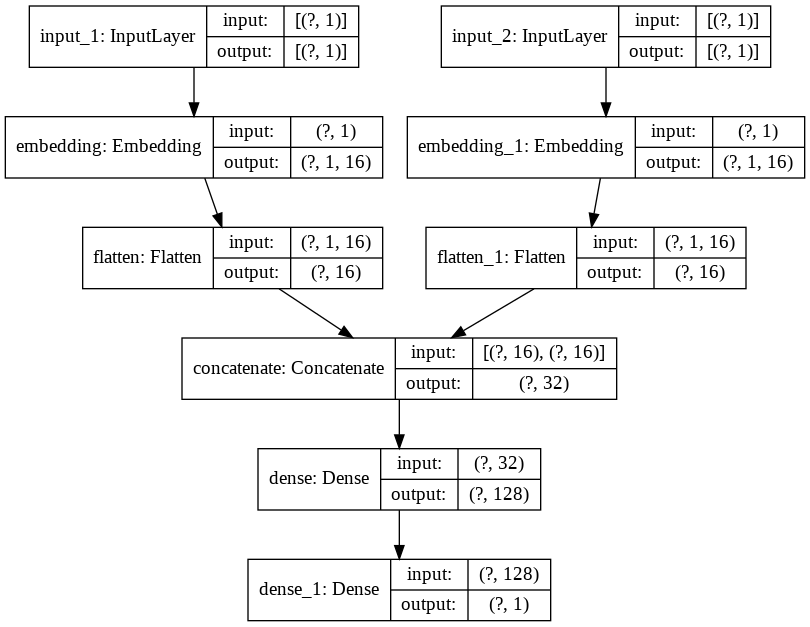

In [6]:
# Building the model using Functional API
# We will create two separate embeddings: one for users, and one for books, then concatenate them together
n_users_index = ratings_df.user_id.nunique()
n_books_index = ratings_df.book_id.nunique()

# For books
books_input = tf.keras.layers.Input(shape=[1])
books_embeddings = tf.keras.layers.Embedding(n_books_index + 1, 16)(books_input)
books_output = tf.keras.layers.Flatten()(books_embeddings)

# For users
users_input = tf.keras.layers.Input(shape=[1])
users_embeddings = tf.keras.layers.Embedding(n_users_index + 1, 16)(users_input)  
users_output = tf.keras.layers.Flatten()(users_embeddings)

# Concatenate
concat = tf.keras.layers.Concatenate()([books_output, users_output])
x1 = tf.keras.layers.Dense(128, activation="relu")(concat)
x2 = tf.keras.layers.Dense(1, activation="relu")(x1)  # Ratings for each book in the train dataset
model = tf.keras.Model([books_input, users_input], x2, name="book_user_model")

# Plotting the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [7]:
# Compiling our model
optimizer = tf.keras.optimizers.Adam(lr=1e-4)

# Finding the best learning rate
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10 ** (epoch / 10)
)
callbacks = [lr_schedule]

model.compile(optimizer=optimizer,
              loss="mse")

print(model.summary())

# Training the model
history = model.fit([X_train.book_id, X_train.user_id],
                    X_train.rating,
                    batch_size=64,
                    epochs=30,
                    validation_data=([X_test.book_id, X_test.user_id], X_test.rating),
                    callbacks=callbacks,
                    verbose=1)


Model: "book_user_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 16)        160016      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 16)        854800      input_2[0][0]                    
____________________________________________________________________________________

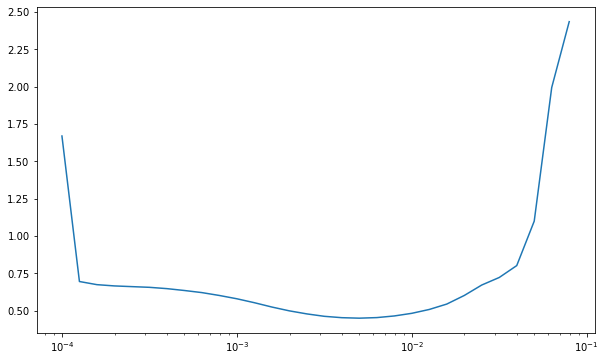

In [10]:
plt.figure(figsize=(10, 6))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.show()

In [12]:
# Best learning rate at 1e-3
# So let's define a final model and train our dataset on it for 3 epochs
books_input = tf.keras.layers.Input(shape=[1])
books_embeddings = tf.keras.layers.Embedding(n_books_index + 1, 16)(books_input)
books_output = tf.keras.layers.Flatten()(books_embeddings)
users_input = tf.keras.layers.Input(shape=[1])
users_embeddings = tf.keras.layers.Embedding(n_users_index + 1, 16)(users_input)
users_output = tf.keras.layers.Flatten()(users_embeddings)
concat = tf.keras.layers.Concatenate()([books_output, users_output])
x1 = tf.keras.layers.Dense(128, activation="relu")(concat)
x2 = tf.keras.layers.Dense(1, activation="relu")(x1)  # Ratings for each book in the train dataset
f_model = tf.keras.Model([books_input, users_input], x2, name="final_book_user_model")

optimizer = tf.keras.optimizers.Adam(lr=1e-3)
f_model.compile(optimizer=optimizer,
                loss="mse")

f_history = f_model.fit([X_train.book_id, X_train.user_id],
                        X_train.rating,
                        batch_size=128, #  For quicker training
                        epochs=3,
                        verbose=1,
                        validation_data=([X_test.book_id, X_test.user_id], X_test.rating))

# Saving the model
!mkdir -p saved_model
f_model.save("saved_model/my_book_user_model")





Epoch 1/3
6136/6136 [==============================] - 58s 10ms/step - loss: 0.9327 - val_loss: 0.7206
Epoch 2/3
6136/6136 [==============================] - 59s 10ms/step - loss: 0.6813 - val_loss: 0.7092
Epoch 3/3
6136/6136 [==============================] - 58s 9ms/step - loss: 0.6449 - val_loss: 0.7004
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/my_book_user_model/assets


In [13]:
# Finally let's see the book recommendation for the 5th user

# We do this by passing both the list of all books and the corresponding user
# index (in this case 5) to the model. Note that they have to have the same shape.
books_index = list(ratings_df.book_id.unique())
books_array = np.array(books_index)
user5_array = np.array([5 for _ in range(len(books_array))])


user5_predicted_book_ratings = f_model.predict([books_array, user5_array])
user5_predicted_book_ratings = user5_predicted_book_ratings.reshape(-1)



# Finding the books with the highest predicted ratings
highest_predicted_book_index = user5_predicted_book_ratings.argsort()
top10_predicted_book_index = highest_predicted_book_index[0:10]


# Locating the top 10 books from the books_df and show the most important
# features only
important_features = ["title", "authors", "original_publication_year", "isbn", "isbn13", "image_url"]
trunc_books_df = books_df[important_features]
trunc_books_df.iloc[top10_predicted_book_index]


,title,authors,original_publication_year,isbn,isbn13,image_url
1792,One Night at the Call Center,Chetan Bhagat,2005.0,345498321,9.780345e+12,https://images.gr-assets.com/books/1320500924m...
1821,"Revolution 2020: Love, Corruption, Ambition",Chetan Bhagat,2011.0,8129118807,9.788129e+12,https://images.gr-assets.com/books/1317964666m...
4044,Half Girlfriend,Chetan Bhagat,2014.0,8129135728,9.788129e+12,https://images.gr-assets.com/books/1407223058m...
4008,Four Blondes,Candace Bushnell,2000.0,080213825X,9.780802e+12,https://s.gr-assets.com/assets/nophoto/book/11...
4398,Mein Kampf,Adolf Hitler,1925.0,395083621,9.780395e+12,https://images.gr-assets.com/books/1395618385m...
7635,Of Course I Love You...! Till I Find Someone B...,"Durjoy Datta, Maanvi Ahuja",2008.0,8188575658,9.788189e+12,https://images.gr-assets.com/books/1274597947m...
8873,Tell-All,Chuck Palahniuk,2010.0,385526350,9.780386e+12,https://images.gr-assets.com/books/1320495064m...
33,"Fifty Shades of Grey (Fifty Shades, #1)",E.L. James,2011.0,1612130291,9.781612e+12,https://images.gr-assets.com/books/1385207843m...
1408,The 3 Mistakes of My Life,Chetan Bhagat,2008.0,NaN,9.788129e+12,https://s.gr-assets.com/assets/nophoto/book/11...
5705,حبيبتي بكماء,محمد السالم,2013.0,NaN,NaN,https://images.gr-assets.com/books/1377064343m...
